In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 11 14:35:34 2022

@author: User
"""



###############################################################################
### 라이브러리 불러오기
###############################################################################

import os
import time
import copy

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
#%matplotlib inline

import torch
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


from torchvision.datasets import ImageFolder
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from torchsummary import summary

from time import perf_counter, sleep
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
train_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/train.csv')
test_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/test.csv')

In [4]:
# import shutil

# send_folder = 'C:/Users/sanda/Desktop/dacon/train_imgs_vector/'
# receive_foler = 'C:/Users/sanda/Desktop/dacon/train_imgs_vector_class/c0'

In [5]:
# cnt = 0

# for i , row in train_df.iterrows():
#     if row['N_category'] == 0:
#         cnt +=1
#         file_name = row['img_path'].split('/')[-1].split('.')[0]
#         shutil.copy(send_folder+file_name+'.npy' , receive_foler)
        
# print(cnt)

In [6]:
CFG = {
    'IMG_SIZE':224, # fixed
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [7]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [8]:
###############################################################################
## data
###############################################################################
#import splitfolders



#Hand_craft_bounding
input_folder_path = 'C:/Users/sanda/Desktop/dacon/train_imgs_vector_class/original'
output_folder_path = 'C:/Users/sanda/Desktop/dacon/train_imgs_vector_class/train_test'

# import splitfolders

# if not os.path.isdir(output_folder_path):
    
#     os.makedirs(output_folder_path)
    
# splitfolders.ratio(input_folder_path,output = output_folder_path,ratio=(0.8,0.2))

In [9]:
# ###############################################################################
# ### 데이터 불러오기 with 간단한 전처리 
# ###############################################################################

# image_resize = (224,224)

# T = transforms.Compose([
                        
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.RandomRotation(degrees=20),
#                         transforms.RandomHorizontalFlip(p=0.5),
#                         transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0),
#                         transforms.Resize(image_resize), # (h, w) 순서
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.5), (0.5))
                   
#                        ])

# valid_T = transforms.Compose([
                        
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.Resize(image_resize), # (h, w) 순서
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.5), (0.5))

#                        ])

# train_dataset = ImageFolder(root=os.path.join(output_folder_path,'train'), transform=T)
# val_dataset = ImageFolder(root=os.path.join(output_folder_path,'val'),transform =valid_T)

In [10]:
def npy_loader(path):
    #sample = torch.from_numpy(np.load(path))
    sample = np.load(path)
    return sample

In [11]:
###############################################################################
### 데이터 불러오기 with 간단한 전처리 
###############################################################################

# fixed

T = transforms.Compose([
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.RandomRotation(degrees=20),
#                         transforms.RandomHorizontalFlip(p=0.5),
#                         transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0),
#                         transforms.Resize(image_resize), # (h, w) 순서
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5), (0.5))
                   
                       ])

valid_T = transforms.Compose([
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.Resize(image_resize), # (h, w) 순서
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5), (0.5))

                       ])

train_dataset = DatasetFolder(root=os.path.join(output_folder_path,'train'), loader=npy_loader,extensions=['.npy'],transform=T)
val_dataset = DatasetFolder(root=os.path.join(output_folder_path,'val'),loader=npy_loader,extensions=['.npy'],transform =valid_T)

In [12]:
###############################################################################
### DataLoader, batch_size, shuffle, .... 
###############################################################################
batch_size = 4
# #batch_size = 4
# #num_workers = 4 * torch.cuda.device_count()
num_workers = 0 #수정

train_loaders = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers , pin_memory=True)
val_loaders = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


dataloaders = dict()
dataloaders['train'] = train_loaders
dataloaders['val'] = val_loaders

In [13]:
# ###############################################################################
# ###데이터가 잘 load 되었는지 확인하기
# ###############################################################################

# images, labels =  iter(train_loaders).next()

# MEAN = torch.tensor([0.5])
# STD = torch.tensor([0.5])
# for data, i in train_loaders:
#     print(data.shape) # (batch_size, c, h, w)
    
#     data = data*STD+MEAN
#     tmp_data = data.numpy().transpose(0, 2, 3, 1) 
#     img = tmp_data[3]
#     plt.imshow(img)
#     plt.show()
    
#     break

In [14]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1a41aee6f40>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1a41aee6fd0>}

In [15]:
# ###############################################################################
# ### (Pre-Trained) Model resnet 로드 및 확인
# ###############################################################################
# #model = torchvision.models.resnet34(pretrained=True)

# #model = torchvision.models.resnet50(pretrained=True)
# #model = torchvision.models.resnet152(pretrained=True)
# model = torchvision.models.resnet152(pretrained=True)

# layer_set = []
# layer_names = []

# for name, layer in model.named_modules():
#     layer_set.append(layer)
#     layer_names.append(name)

# layer_names[1]
# layer_names[-1]

# #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)#
# #model.fc = nn.Linear(in_features=512, out_features=3, bias=True)

# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

In [16]:
# ###############################################################################
# ### (Pre-Trained) Model resnet 로드 및 확인
# ###############################################################################
# #model = torchvision.models.resnet34(pretrained=True)

# #model = torchvision.models.resnet50(pretrained=True)
# #model = torchvision.models.resnet152(pretrained=True)
# model = torchvision.models.convnext_tiny(pretrained=False)

# layer_set = []
# layer_names = []

# for name, layer in model.named_modules():
#     layer_set.append(layer)
#     layer_names.append(name)

# # layer_names[1]
# # layer_names[-1]

# #model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)#
# #model.fc = nn.Linear(in_features=512, out_features=3, bias=True)

# # model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# # model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

# model.conv1 = nn.Conv2d(96,3,kernel_size=(3,3)) #fixed
    
# model.fc = nn.Linear(in_features=1000, out_features=1), # fixed

In [17]:
class ImgFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImgFeatureExtractor, self).__init__()
        #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
        self.backbone = torchvision.models.convnext_tiny(pretrained=False)
        #self.backbone = models.convnext_base(pretrained=False)
        self.first_conv = nn.Conv2d(96,3,kernel_size=(3,3)) #fixed
        #self.embedding = nn.Linear(1000,512) # fixed
        #self.embedding = nn.Linear(1000,128)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=1000, out_features=2), # fixed
            #nn.Linear(in_features=1024, out_features=1),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.first_conv(x) #fixed
        x = self.backbone(x)
        #x = self.embedding(x) #fixed
        x = self.classifier(x)
        return x

In [18]:
model = ImgFeatureExtractor()

In [19]:
###############################################################################
### GPU 세팅
###############################################################################


#GPU 세팅
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
model = model.to(device)

In [20]:
print(device)

cuda


In [21]:
###############################################################################
### Trainin  Setting
###############################################################################


optimizer = optim.Adam(model.parameters(), lr=0.0001)# 손실함수 정의 및 업데이트 방법결정
criterion = nn.CrossEntropyLoss()

#epoch에 따라 학습률 조절: 기본적으로 epoch이 증가함에 따라 학습률 감소 시킴
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)#7단계 마다 0.1비율만큼 학습률 감소

In [22]:
gc.collect()

9

In [23]:
# def force_cudnn_initialization():
#     s = 32
#     dev = torch.device('cuda')
#     torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
# force_cudnn_initialization()

Epoch 0/49
----------
train Loss: 0.7685 Acc: 49.5620
val Loss: 0.6962 Acc: 48.7562
==> best model saved - 0 / 48.8
1epoch-gpu Time taken to execute code : 98.1988134
Epoch 1/49
----------
train Loss: 0.7292 Acc: 49.4368
val Loss: 0.7005 Acc: 51.2438
==> best model saved - 1 / 51.2
1epoch-gpu Time taken to execute code : 95.7325763
Epoch 2/49
----------
train Loss: 0.7053 Acc: 51.6896
val Loss: 0.7170 Acc: 48.7562
1epoch-gpu Time taken to execute code : 95.71052779999997
Epoch 3/49
----------
train Loss: 0.7102 Acc: 49.1865
val Loss: 0.7052 Acc: 51.2438
1epoch-gpu Time taken to execute code : 95.86252280000002
Epoch 4/49
----------
train Loss: 0.7065 Acc: 49.8123
val Loss: 0.7000 Acc: 48.7562
1epoch-gpu Time taken to execute code : 95.42792779999996
Epoch 5/49
----------
train Loss: 0.7051 Acc: 49.4368
val Loss: 0.7022 Acc: 48.7562
1epoch-gpu Time taken to execute code : 95.542326
Epoch 6/49
----------
train Loss: 0.7051 Acc: 49.9374
val Loss: 0.7135 Acc: 51.2438
1epoch-gpu Time taken 

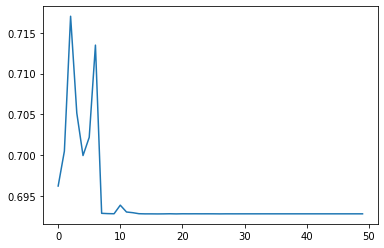

In [24]:
###############################################################################
### Trainining Process
###############################################################################


best_model_weights = copy.deepcopy(model.state_dict())




best_acc = 0.0
epoch_loss_history = []
epoch_acc_history = []
val_acc_history = []
val_loss_history = []



start = perf_counter()

epochs = 50


for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)
    
    start_gpu = perf_counter()
    
    for phase in ['train','val']:
    
        if phase == 'train':

            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        num_cnt  = 0
    
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
    

            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
            
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                

                loss = criterion(outputs, labels)
                
                if phase=='train':
                

                    loss.backward()

                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) 
            running_corrects += torch.sum(preds == labels.data)
            num_cnt += len(labels)
                
        if phase == 'train':
            
            scheduler.step()

        epoch_loss = float(running_loss/num_cnt)
        epoch_acc = float((running_corrects.double()/num_cnt).cpu()*100)
    
        if phase == 'train':
    
            epoch_loss_history.append(epoch_loss)
            epoch_acc_history.append(epoch_acc)
    
        else:
    
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)
            
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    

        if phase=='val' and epoch_acc > best_acc:
            
            best_idx = epoch
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
        
          
    end_gpu = perf_counter()
    print(f"1epoch-gpu Time taken to execute code : {end_gpu-start_gpu}")    


end = perf_counter()
print(f"Time taken to execute code : {end-start}")      
print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))     


plt.plot(val_loss_history)
#plt.plot(val_acc_history)

gc.collect()
torch.cuda.empty_cache()

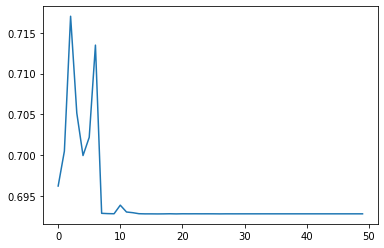

In [25]:
plt.plot(val_loss_history)

In [26]:
# ###############################################################################
# ### best model 저장
# ###############################################################################

# update_model_path = '/content/drive/MyDrive'
# torch.save(best_model_wts,os.path.join(update_model_path,'hair_loss_detection_best_model_size_224_by_224_ver2.pt'))